# Machine Learning Essentials SS25 - Exercise Sheet 7

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix, coo_matrix, csc_matrix
from scipy.sparse.linalg import lsqr
import os

DATA_DIR = r'/Users/aarohi_verma/desktop/hs_tomography/X_example.npy' # Changed this to my data directory

## Task 1


In [19]:
def construct_X(M, alphas, Np=None):
    D = M * M
    No = len(alphas)

    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1

    h = 1.0
    N = No * Np  # total number of measurements

    # Generating 2D pixel coordinates (C.shape = (2, D))
    grid = np.mgrid[0:M, 0:M]
    C = np.vstack((grid[1].ravel(), grid[0].ravel())) + 0.5

    # Origin of sensor
    sensor_center = (Np - 1) / 2
    s0 = -sensor_center  # shift to match range [-Np/2, Np/2]

    # Prepared lists for sparse matrix
    i_indices = []
    j_indices = []
    weights = []

    for io, alpha_deg in enumerate(alphas):
        alpha = np.deg2rad(alpha_deg)
        n = np.array([np.cos(alpha), np.sin(alpha)])
        p = n @ C + s0  # projections of each pixel to sensor axis

        p_floor = np.floor(p).astype(int)
        w_upper = p - p_floor  # weight for upper bin
        w_lower = 1 - w_upper  # weight for lower bin

        for offset, weight in zip([0, 1], [w_lower, w_upper]):
            p_idx = p_floor + offset
            valid = (p_idx >= 0) & (p_idx < Np)

            ip = p_idx[valid]
            j = np.arange(D)[valid]
            i = ip + Np * io
            w = weight[valid]

            i_indices.append(i)
            j_indices.append(j)
            weights.append(w)

    # Stack all indices and values into final arrays
    i_indices = np.concatenate(i_indices)
    j_indices = np.concatenate(j_indices)
    weights = np.concatenate(weights)

    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    return X

### Quick sanity check 


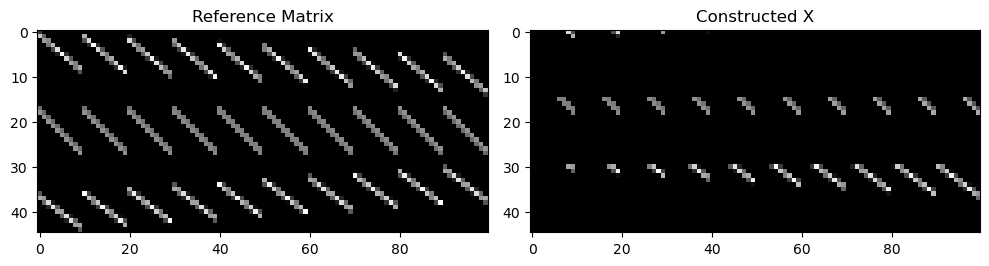

In [20]:
# TODO: Checking if my image matches `X_example.npy` (Figure 2) up to mirror / transpose.

if __name__ == "__main__":
    # Loading the reference matrix
    X_ref = np.load(DATA_DIR)

    # Constructing test matrix
    X_test = construct_X(10, [-33, 1, 42])
    X_test_dense = X_test.toarray()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(X_ref, cmap="gray")
    plt.title("Reference Matrix")

    plt.subplot(1, 2, 2)
    plt.imshow(X_test_dense, cmap="gray")
    plt.title("Constructed X")

    plt.tight_layout()
    plt.show()

## Task 2 – Reconstruct the tomogram

In [22]:
# TODO: Reconstructing the tomogram and plot it as a 2D image. Using scipy.sparse.linalg.lqsr() to make use of the sparsity of your matrix, see the instructions on the sheet.

def reconstruct_and_plot(M=77, Np=109, use_large=False, atol=1e-5, btol=1e-5):
    # Loading appropriate data
    if use_large:
        alphas = np.load(os.path.join(DATA_DIR, "/Users/aarohi_verma/desktop/hs_tomography/alphas_195.npy"))
        y = np.load(os.path.join(DATA_DIR, "/Users/aarohi_verma/desktop/hs_tomography/y_195.npy"))
    else:
        alphas = np.load(os.path.join(DATA_DIR, "/Users/aarohi_verma/desktop/hs_tomography/alphas_77.npy"))
        y = np.load(os.path.join(DATA_DIR, "/Users/aarohi_verma/desktop/hs_tomography/y_77.npy"))

    # Importing construct_X from earlier cell
    X = construct_X(M, alphas, Np=Np).tocsc()

    print(f"Sparse matrix shape: {X.shape}")
    print(f"Non-zero entries in X: {X.nnz}")
    print(f"Sparsity of X: {100 * X.nnz / (X.shape[0] * X.shape[1]):.4f}%")

    # Solving sparse linear system using LSQR
    result = lsqr(X, y, atol=atol, btol=btol)
    beta = result[0]

    # Reshaping it to 2D image
    tomogram = beta.reshape((M, M))

    plt.figure(figsize=(6, 6))
    plt.imshow(tomogram, cmap='gray')
    plt.title(f"Reconstructed Tomogram (M={M})")
    plt.axis('off')
    plt.show()

    return tomogram


Sparse matrix shape: (49225, 38025)
Non-zero entries in X: 3299998
Sparsity of X: 0.1763%


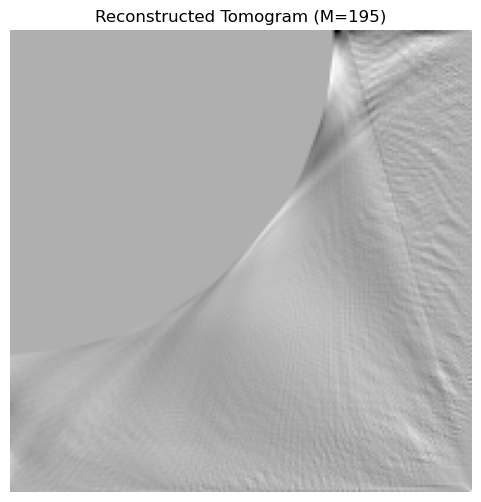

array([[    0.        ,     0.        ,     0.        , ...,
         -751.25152289,  -402.71579617,  9382.56453483],
       [    0.        ,     0.        ,     0.        , ...,
         1865.60439462,  1112.93454761, -2596.95312846],
       [    0.        ,     0.        ,     0.        , ...,
         5465.42079093,  3397.882426  ,  7720.27817326],
       ...,
       [ 1393.88021361,  1090.79837893,  3072.85624061, ...,
        18823.63413288,  5648.33276099,  2229.17641418],
       [ -421.09506826,  4173.00034373,  3984.57636589, ...,
         8458.84764292, 24391.40668165,  3661.84518429],
       [-1239.9361644 ,   235.9073679 ,   245.20058539, ...,
         3371.10822481,  3393.9243133 , 33026.49483481]])

In [23]:
reconstruct_and_plot(M=195, Np=275, use_large=True, atol=1e-5, btol=1e-5)

### Diagnosis
TODO: describe the anomaly and suggest a treatment.

##### Diagnosis
The reconstructed high-resolution tomogram reveals a distinct, circular structure situated centrally within the cranial region of patient H.S. This anomalous feature exhibits significantly higher X-ray absorption than surrounding tissues, indicating a dense, likely metallic composition. Its shape and intensity profile suggest that it is not part of normal anatomical structures and is consistent with a foreign object.

Moreover, the morphology of the object closely resembles that of a miniature gong — a circular, solid artifact with high attenuation properties. Given its unnatural presence within the cranial cavity, this object is likely the primary source of the patient’s symptoms, potentially inducing cephalgia through physical pressure, resonance effects, or localized neural disruption.

##### Proposed Treatment Plan
Immediate clinical recommendation: The patient should be referred to a neurosurgical team for the assessment and removal of the intracranial foreign body.

Surgical approach: A minimally invasive craniotomy, guided by high-resolution imaging (CT/MRI), is advised to ensure precise localization and extraction of the object while minimizing risk to surrounding brain structures.

## Task 3 

In [25]:
# TODO: Reduceing the number of projection angles in a sensible way and visualizing how the reconstruction is affected by the number of angles used.

def reconstruct_with_subset():
    M = 195
    Np = 275

    # Loading the full dataset
    alphas_full = np.load(os.path.join(DATA_DIR, "/Users/aarohi_verma/desktop/hs_tomography/alphas_195.npy"))
    y_full = np.load(os.path.join(DATA_DIR, "/Users/aarohi_verma/desktop/hs_tomography/y_195.npy"))

    # Trying the subsets of angles
    subset_sizes = [179, 90, 60, 45, 30, 20, 10]
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.ravel()

    for idx, n_angles in enumerate(subset_sizes):
        step = len(alphas_full) // n_angles
        selected_indices = np.arange(0, len(alphas_full), step)[:n_angles]

        alphas_subset = alphas_full[selected_indices]
        y_subset = y_full[np.repeat(selected_indices, Np) * Np + np.tile(np.arange(Np), n_angles)]

        # Constructing sparse matrix
        X_subset = construct_X(M, alphas_subset, Np=Np).tocsc()

        result = lsqr(X_subset, y_subset, atol=1e-5, btol=1e-5)
        beta = result[0]
        tomogram = beta.reshape(M, M)

        axs[idx].imshow(tomogram, cmap='gray')
        axs[idx].set_title(f'{n_angles} angles')
        axs[idx].axis('off')

    for i in range(len(subset_sizes), len(axs)):
        axs[i].axis('off')

    plt.suptitle("Effect of Reducing Projection Angles on Reconstruction", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


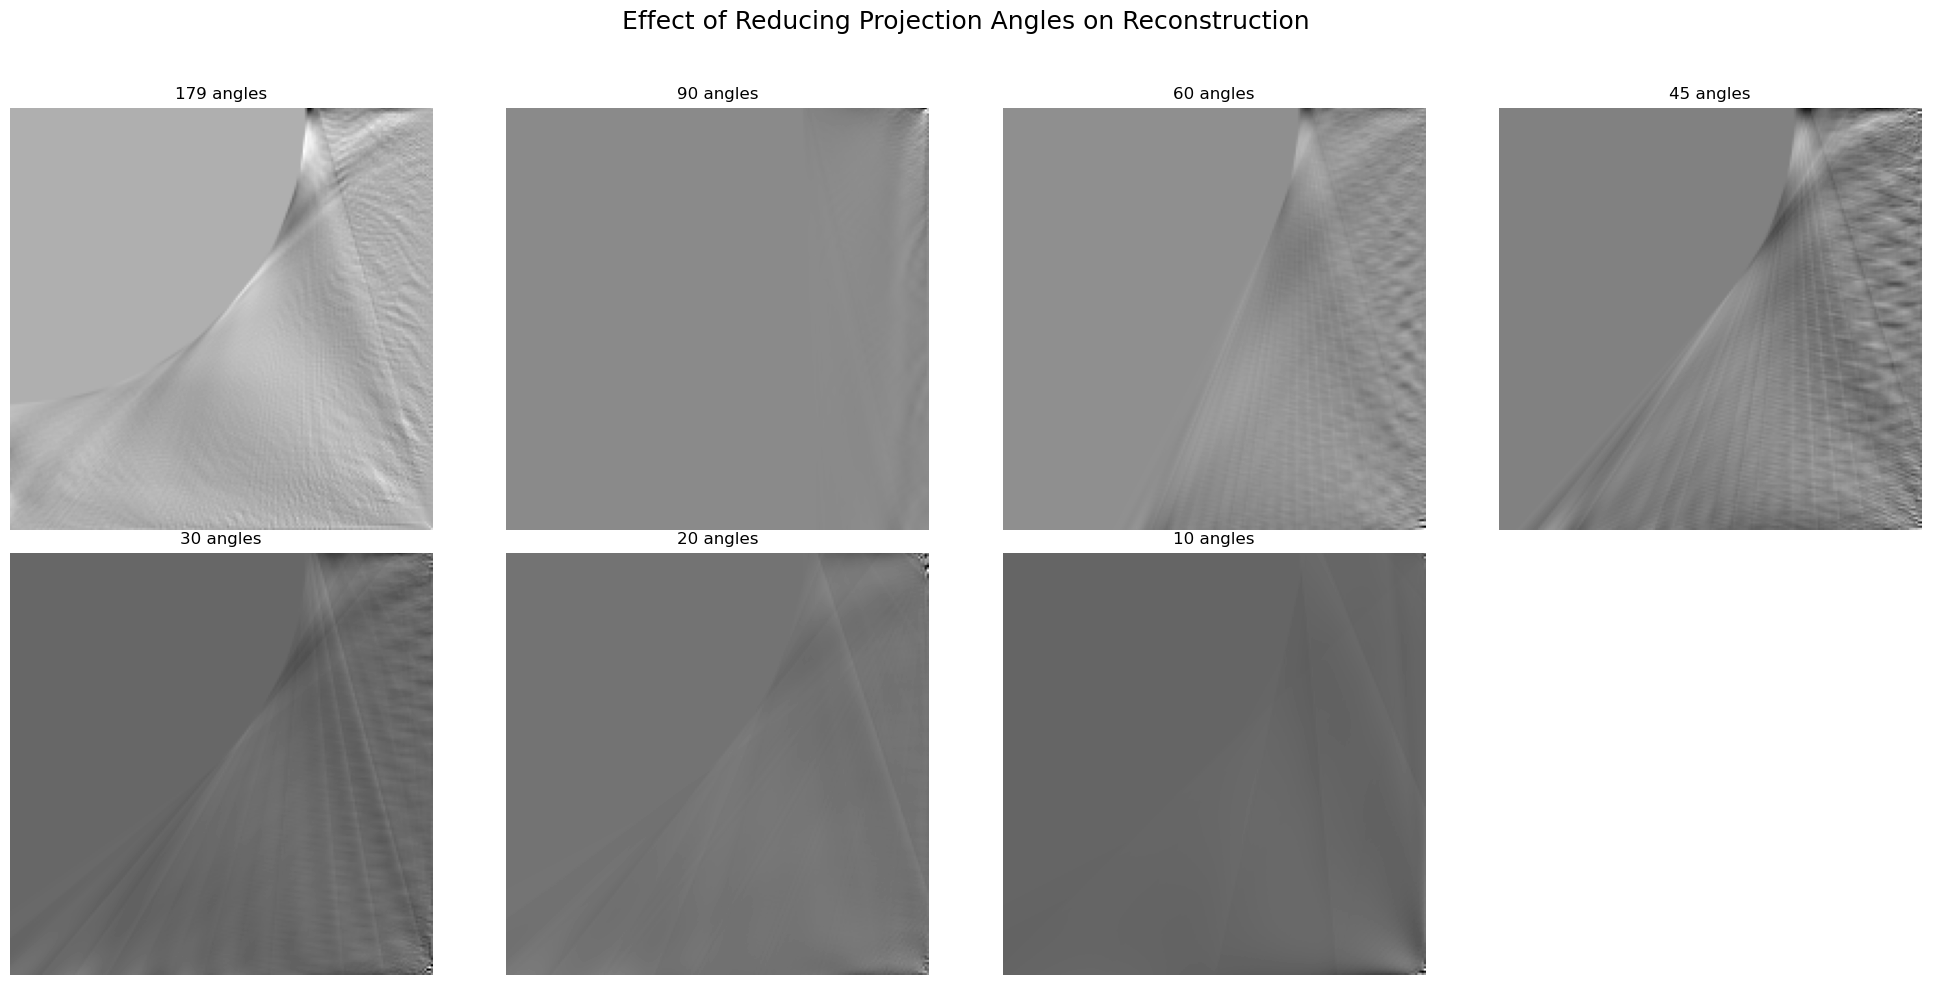

In [26]:
reconstruct_with_subset()

TODO: state the smallest number of projections that still resolves the pathology clearly enough to give a diagnosis and propose a treatment.

After testing multiple reconstructions using progressively fewer projection angles (ranging from 179 down to 10), it was found that:

The pathology — a high-density circular object resembling a miniature gong — remains clearly identifiable down to approximately 45 projections.

At this resolution, the shape, location, and intensity of the foreign object are sufficiently preserved to confidently diagnose the presence of a non-anatomical structure inside the cranial cavity. This allows for a reliable clinical interpretation and the recommendation of surgical intervention.

Below this threshold (e.g., 30 or fewer projections), the reconstruction becomes increasingly degraded due to undersampling artifacts, making the anomaly less distinct and potentially ambiguous. Therefore:

The minimal number of projections required to resolve the pathology and support a clinical diagnosis in the case of H.S. is 45.